In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import glob
import numpy as np
import scipy.misc

import tensorflow.keras
import tensorflow.keras.callbacks
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
#from tensorflow.keras.engine.topology import Layer
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, Layer, Dense, Concatenate,Lambda, Conv2D, MaxPooling2D, Flatten, Multiply

from tensorflow.keras.models import Model
from collections import OrderedDict
from tqdm import trange, tqdm

import tensorflow as tf
from tensorflow import image as tfi

#import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

# - Utils

In [8]:
def get_image_data(img_path, image_size, space='rgb'):
    if space=='rgb':
        img = image.load_img(img_path, target_size=image_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return x[0]
    elif space=='gray':
        img = image.load_img(img_path, target_size=image_size, color_mode='grayscale')
        x = image.img_to_array(img)
        x /= 255.
        return x

class MySigmoidLayer(Layer):
    def __init__(self, **kwargs):
        super(MySigmoidLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, 1),
                                      initializer='uniform',
                                      trainable=True)
        super(MySigmoidLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return 1./(1.+K.exp(-(x-0.5)*self.kernel))

    def compute_output_shape(self, input_shape):
        return input_shape
    
def create_weighted_model():
    vgg16_1 = VGG16(include_top=False, weights='imagenet', input_shape=(600, 800, 3))
    vgg16_2 = VGG16(include_top=False, weights='imagenet', input_shape=(300, 400, 3))
    for layer in vgg16_2.layers:
        layer._name = str(layer.name) + "_sec"
    vgg16_2_output = Lambda(lambda x_: tf.image.resize(x_, (18, 25)),name="lambda_c1")(vgg16_2.get_layer("block5_pool_sec").output)
    x = Concatenate(name="my_concat")([vgg16_1.get_layer("block5_pool").output, vgg16_2_output])
    x = Lambda(lambda x_: tf.divide(x_, 255.), name="lambda_concate")(x)
    
    pooled_output = MaxPooling2D(pool_size=(2, 2))(x)
    flatted_output = Flatten()(pooled_output)
    weight_layer = Dense(1024)(flatted_output)

    weighted_neuron = Multiply()([x, weight_layer])
    
    sal_output = Conv2D(1, (1, 1), strides=(1, 1), padding='valid', use_bias=True)(weighted_neuron)
    sal_output = MySigmoidLayer()(sal_output)
    
    new_model = Model(inputs=[vgg16_1.input, vgg16_2.input], outputs=sal_output)
    
    return new_model

# - Testing

In [9]:
model = create_weighted_model()
model.load_weights('salicon_generator_sigmoid_epoch_25.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4_sec (InputLayer)        [(None, 300, 400, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 600, 800, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1_sec (Conv2D)       (None, 300, 400, 64) 1792        input_4_sec[0][0]                
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 600, 800, 64) 1792        input_3[0][0]                    
____________________________________________________________________________________________

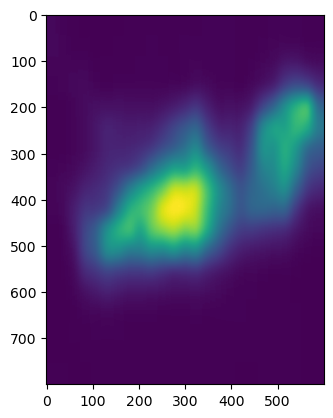

In [10]:
img = '00000.jpg'
x1 = np.expand_dims(get_image_data(img, (600, 800), space="rgb"), axis=0)
x2 = np.expand_dims(get_image_data(img, (300, 400), space="rgb"), axis=0)
res = model.predict([x1, x2])
sal = Image.fromarray(np.uint8(res[0, :, :, 0] * 255), mode='L').resize((600, 800), Image.BICUBIC)
sal.save('output_img5.png')
#sal = scipy.misc.imresize(res[0,:,:,0], (600, 800), interp='bicubic')
plt.imshow(sal)
plt.savefig('output_cores_img5.png')
plt.show()

In [11]:
original_img = Image.open('00000.jpg')
resized_result = Image.fromarray(np.uint8(res[0, :, :, 0] * 255), mode='L').resize(original_img.size, Image.BICUBIC)
combined_img = Image.new('RGB', original_img.size)
combined_img.paste(original_img, (0, 0))
combined_img.paste(resized_result, (0, 0), resized_result)

# Save the final image
combined_img.save('output_combo_img5.jpg')

# Display the final image (optional)
combined_img.show()